In [1]:
from scipy.optimize import nnls
import numpy as np

In [2]:
def power_law_nl(x, a = 1, b = 2):
    return a * x**b

def power_law_inv(y, a = 1, b = 2):
    return (y / a)**(1/b)

In [3]:
#load data (.mat)
import scipy.io as sio
data = sio.loadmat('../../data/Data_cell_types_small_size.mat')

In [4]:
#extract mean activity per cell type
som = data['sst']
som_act = np.mean(som, axis =0)

pv = data['pv']
pv_act = np.mean(pv, axis =0)

vip = data['vip']
vip_act = np.mean(vip, axis =0)

e = data['pyr']
e_act = np.mean(e, axis =0)

Is = data['contrast']

# SBI

In [5]:
import torch

#from sbi import analysis as analysis
from sbi import utils as utils
from sbi.inference import SNPE, simulate_for_sbi
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

c:\Users\linau\anaconda3\envs\sbi_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### define simulator and prior

In [6]:
#prior
from scipy.stats import expon


prior = [torch.distributions.Exponential(torch.tensor([4.0]))]*24


In [7]:
# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior)

c:\Users\linau\anaconda3\envs\sbi_env\lib\site-packages\sbi\utils\user_input_checks.py:76: UserWarning: Prior was provided as a sequence of 24 priors. They will be
            interpreted as independent of each other and matched in order to the
            components of the parameter.
  warnings.warn(


### e and pv

In [19]:
import torch
import numpy as np

# Assuming data and power_law_nl are defined elsewhere

def simulator2(wb):
    # Define inputs
    i = 0
    max_it = 3000
    
    delta_t = 0.05
    r = torch.rand(24)  # Initialize r with shape (4, 6)
    I_values = data['contrast'][0][:6]/torch.tensor([100])  # Get the 6 different I values

    while i < max_it:
        
        for j, I in enumerate(I_values):
            A_1 = torch.tensor([r[j*4], -1 * r[j*4 +1], -1 *r[j*4 +2], -1 * r[j*4+3], I, 1])
            A_2 = torch.tensor([r[j*4], -1 * r[j*4+1], -1* r[j*4+2], -1 * r[j*4+3], 0, 1])
            
            r_delta = -r[j*4:j*4 +4] + power_law_nl(torch.tensor([A_1 @ wb[0:6], A_1 @ wb[6:12], A_2 @ wb[12:18], A_2 @ wb[18:24]])) 
            r[j*4:j*4+4] = r[j*4:j*4+4] + delta_t * r_delta
        
        eps = torch.sum(torch.pow(r_delta, 2))
        if eps < 1e-4 or torch.isnan(eps):
            break
        
        i += 1
    
    return r

In [20]:
simulator = process_simulator(simulator2, prior, prior_returns_numpy)

In [21]:

# Consistency check after making ready for sbi.
check_sbi_inputs(simulator, prior)

In [22]:
inference = SNPE(prior=prior)

In [23]:
# theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)
# print("theta.shape", theta.shape)
# print("x.shape", x.shape)

In [27]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=30000)
print("theta.shape", theta.shape)
print("x.shape", x.shape)

Running 30000 simulations.: 100%|██████████| 30000/30000 [2:50:40<00:00,  2.93it/s]   


theta.shape torch.Size([30000, 24])
x.shape torch.Size([30000, 24])


In [28]:
inference = inference.append_simulations(theta, x)

In [30]:
density_estimator = inference.train(force_first_round_loss=True)

 Neural network successfully converged after 258 epochs.

In [31]:
posterior = inference.build_posterior(density_estimator)

print(posterior) # prints how the posterior was trained

Posterior conditional density p(θ|x) of type DirectPosterior. It samples the posterior network and rejects samples that
            lie outside of the prior bounds.


torch.Size([24])


Drawing 10000 posterior samples: 10871it [00:05, 2034.42it/s]                          


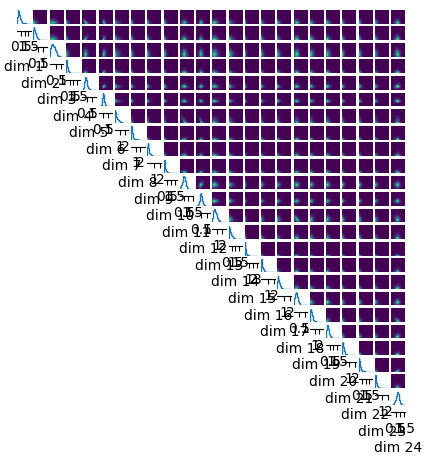

In [40]:
from sbi import analysis as analysis
x_o = []
for i in range(6):
    x_o = x_o + [e_act[i], pv_act[i], som_act[i], vip_act[i]]
x_o = torch.tensor(x_o).squeeze()

posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, figsize=(5, 5)
)

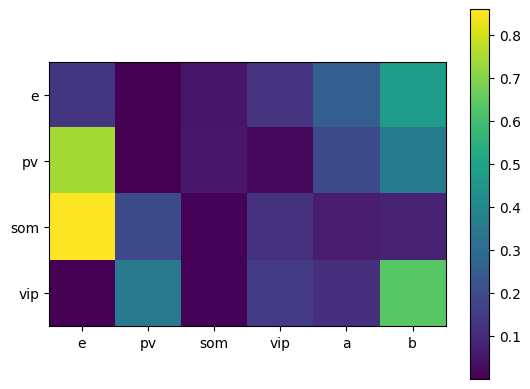

In [41]:
from scipy.stats import mode
from matplotlib import pyplot as plt

weights = mode(posterior_samples.numpy())[0]
weights = weights.reshape(4,6)
plt.imshow(weights)
plt.xticks(np.arange(6), ['e', 'pv', 'som', 'vip', 'a', 'b'])
plt.yticks(np.arange(4), ['e', 'pv', 'som', 'vip'])
plt.colorbar()

In [49]:
samples = posterior.sample((100,), x=x_o)
simulations = simulator(samples)

Drawing 100 posterior samples: 128it [00:00, 346.42it/s]                        


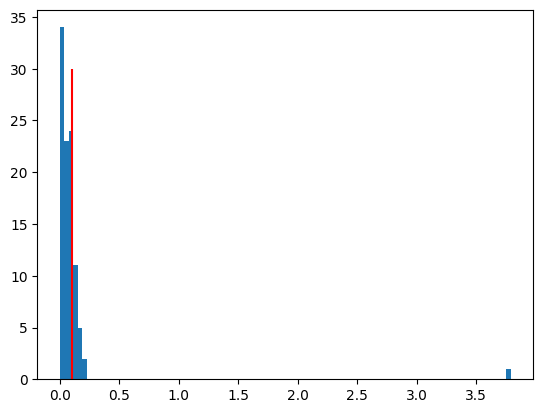

In [55]:
plt.hist(simulations[:,2], bins=100)
plt.vlines(x_o[2], ymax=30, ymin=0, colors='r')